# Demo 1: Flow

Flow is a fundamental driver of processes in the surface and subsurface. In this set of demonstrations we will introduce

  * Richards Model for variably saturated subsurface flow
  * Diffusion Wave model for overland flow (surface flow)
  * A fully coupled (integrated hydrology) model

For each model we will provide the mathematical equations, highlight information about the discretization and provide tips on setting boundary conditions, initial conditions, source terms and key parameters.

## Subsurface Flow (Richards Equation)

Richards (1931) model for variably saturated flow:

$\newcommand{porosity}{\phi}$
$\newcommand{dens}{n_l}$
$\newcommand{sat}{s}$
$\newcommand{flux}{\mathbf{q}}$
$\newcommand{krel}{k_r}$
$\newcommand{kabs}{\kappa}$
$\newcommand{viscosity}{\mu}$

$$
\begin{align}
  \frac{\partial}{\partial t} (\porosity \dens \sat) &+ \nabla \cdot \flux = 0 \\
  \flux &= - \dens \frac{\krel \kabs}{\viscosity} (\nabla p + \rho \mathbf{g})
\end{align}
$$




### Model Setup: Infiltration into a soil column (1D) 
These tests demonstrate solution of Richards equation on a single column. A single column of cells, oriented vertically.

#### Initial conditions 

- hydrostatic profile with the water table at 3m. 

#### Boundary condition

- Infilitration is turned on and water fills the domain. Inward flux is set to 0.05 [mol s].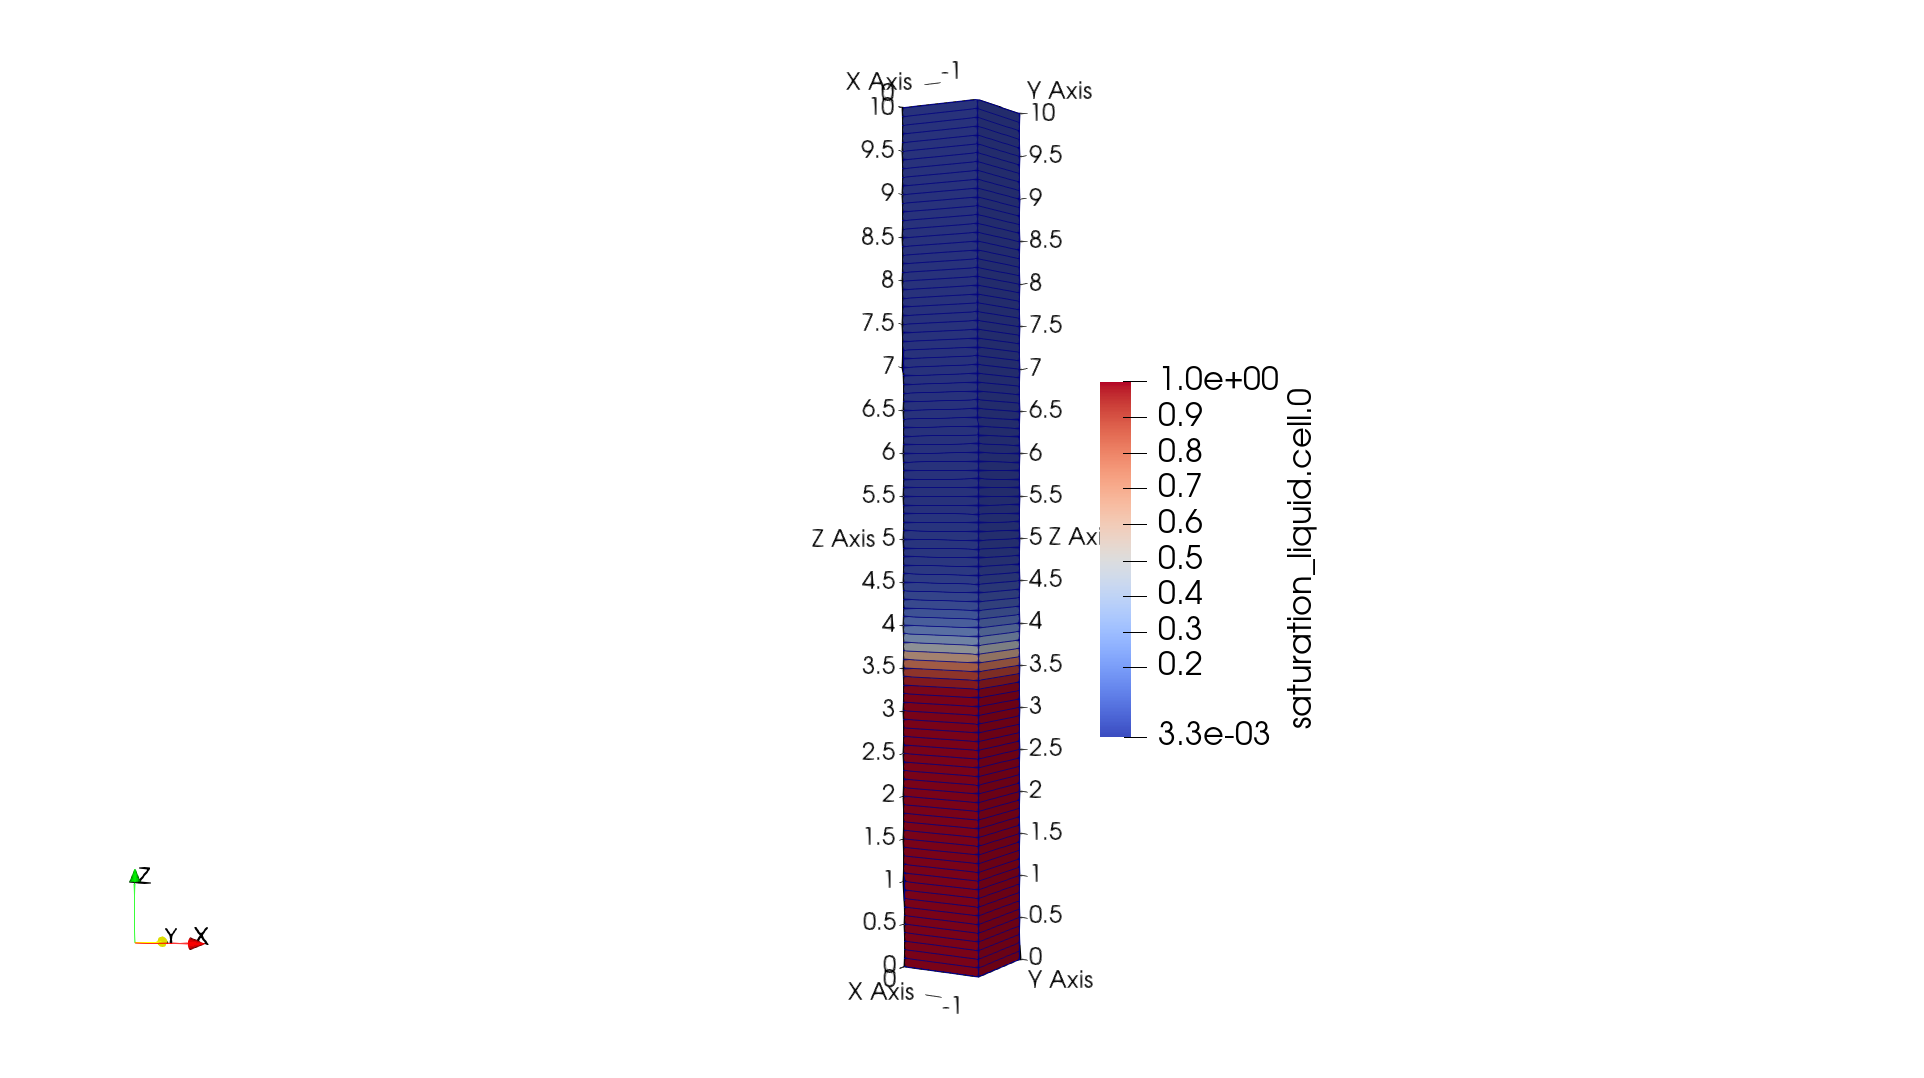

### Simulation Results 
After running the simulation we can plot the results using some of the python utilities provided by ATS. In this case we will plot the saturation as a function of depth, at several times.

In [61]:
%matplotlib inline

In [62]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data
import numpy as np
from matplotlib import pyplot as plt

In [63]:
def plot(dirname, title):
    """A generic plotting function that plots saturation as a function of depth."""
    fig = plt.figure()

    vis = ats_xdmf.VisFile(dirname, time_unit='d')
    vis.loadMesh(columnar=True)
    
    # plot the solution
    ax = fig.subplots(1,1)
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], ax, None, cmap='jet')
    ax.set_title(title)
    ax.set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

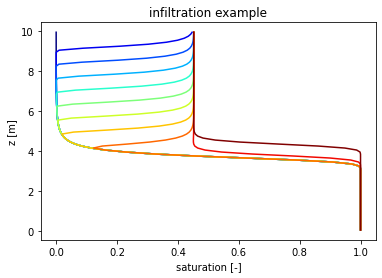

In [64]:
plot("./richards/run/", "infiltration example")

Text(0, 0.5, '$mol\\cdot m^{-2}\\cdot s^{-1}$')

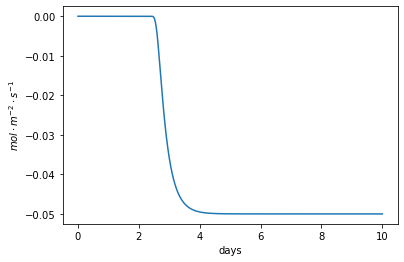

In [65]:
import numpy as np
from matplotlib import pyplot as plt

flux_data = np.loadtxt("./richards/run/observation_flux.dat",skiprows=11)
flux_data = np.transpose(flux_data)
fig = plt.figure()
ax = fig.subplots(1,1)
plt.plot(flux_data[0]/86400, flux_data[1])
ax.set_xlabel("days")
ax.set_ylabel(r"$mol\cdot m^{-2}\cdot s^{-1}$")


## Overland Flow (Diffusion Wave Equation)

Diffusion wave model for overland flow

$\newcommand{pondeddepth}{h_w}$
$\newcommand{watersource}{q_w}$
$\newcommand{flux}{{\bf U_w}}$
$\newcommand{manning}{n_{man}}$



$$
\begin{align}
  \frac{\partial \pondeddepth}{\partial t}  &+ \nabla \cdot \pondeddepth \flux = \watersource \\
  \flux &= -\displaystyle\frac{\pondeddepth^{2/3}}{\manning\left(||\nabla Z_s|| + \varepsilon\right)^{1/2}}
  \nabla\left(\nabla Z_s + \pondeddepth\right)
\end{align}
$$


$\pondeddepth$ - ponded depth
$\watersource$ - water source
$Z_s$ - surface elevation
$\manning$ - Manning’s coefficient


### Model Setup: Rainfall on a Hillslope 

This demonstration simulates a rainfall event over a hillslope domain with different boundary conditions. 

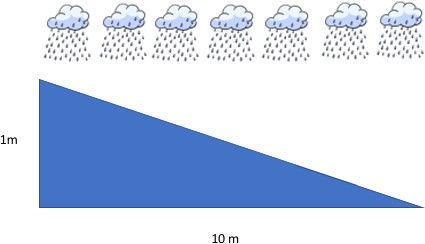

#### Boundary conditions:

A complete description of supported boundary conditions is provided in the documentation of the input specification online, e.g., for flow BCs see [ATS input specification v1.2 - flow-specific-boundary-conditions](https://github.com/amanzi/ats/blob/master/docs/documentation/source/input_spec/ATSNativeSpec_1_2.rst#flow-specific-boundary-conditions).  Here we focus on four important boundary conditions for surface flow.

**No-Flow**: 

The default boundary condition is no-flow, and is set with an empty list,

```xml
<ParameterList name="boundary conditions" type="ParameterList">
</ParameterList>
```

**Critical Depth**: 

This is an _outlet_ boundary condition which looks to set an outward flux to take away runoff. This condition is given by the following condition on outward flux 

$$q = \sqrt{g\hat z} n_{w} h^{3/2}$$

It is described in the input spec as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="critical depth" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
    </ParameterList>
  </ParameterList>
</ParameterList>
```


**Zero Head Gradient:**

This is an _outlet_ boundary condition which looks to enforce the condition that

$$ \nabla h \cdot n = 0 $$

but should only be used on boundaries where

$$ \nabla Z \cdot n  < 0 $$

This is expressed in the input file as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="zero gradient" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
    </ParameterList>
  </ParameterList>
</ParameterList>
```    

**Max Head or Surface Seepage:**

This allows water to flow out once the ponded depth exceeds the specified head, but does not allow flow back into the domain:

if ${\bf U}_w\cdot n < 0$ then we set ${\bf U}_w\cdot n = 0$

if $ h > h_{max}$ then we set $h = h_{max}$

And is written in the input file as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="seepage face head" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
      <ParameterList name="boundary head" type="ParameterList">
        <ParameterList name="function-constant" type="ParameterList">
          <Parameter name="value" type="double" value="0.025" />
        </ParameterList>
      </ParameterList>
    </ParameterList>
  </ParameterList>
</ParameterList>
```

#### Simulation Results

In [66]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import colors
import numpy as np
from matplotlib import pyplot as plt
import pandas

In [67]:
def plot_surface(directory):
    """A generic plotting script plotting ponded depth and discharge/runoff"""
    vis = ats_xdmf.VisFile(directory, domain='surface', time_unit='s')
    vis.loadMesh(order=['x','y'])

    cm = colors.cm_mapper(vis.times[0], vis.times[-1], cmap='jet')
    x = vis.centroids[:,0]

    fig, ax = plt.subplots(1,2, figsize=(14,3))

    # This simply gets a colorbar axis
    C = [[0,0],[0,0]]
    C3 = ax[0].contourf(C, vis.times, cmap='jet')
    ax[0].cla()  

    pd = vis.getArray('surface-ponded_depth')
    elev = vis.get('surface-elevation', '0')

    #ax[0].plot(x, elev, 'k')
    for i,time in enumerate(vis.times):
        #ax[0].plot(x, elev + pd[i,:], color=cm(i))
        #print(cm(i))
        ax[0].plot(x, pd[i,:], color=cm(time))

    ax[0].set_xlabel('x-coordinate [m]')
    ax[0].set_ylabel('ponded depth [m]')
    
    hydro = np.loadtxt(os.path.join(directory, 'surface_outlet_flux.dat'), skiprows=11)
    hydro = np.transpose(hydro)
    ax[1].plot(hydro[0][:]/60.0, hydro[1][:], 'b')
    ax[1].set_xlabel('time [min]')
    ax[1].set_ylabel('discharge flow rate [mol/s]')
    
    cbar = plt.colorbar(C3, ax=ax[0])
    cbar.ax.set_ylabel("time [s]")
    
    plt.tight_layout()
    plt.show()

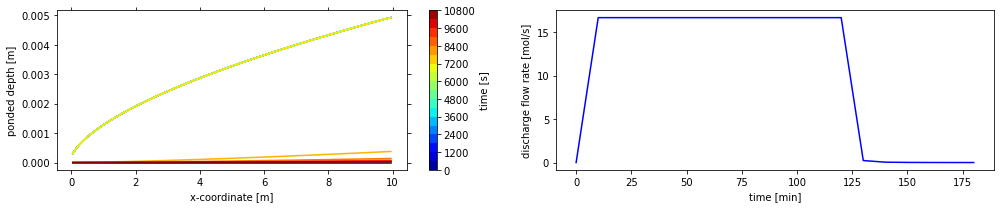

In [68]:
plot_surface("overland_flow/run_1D")

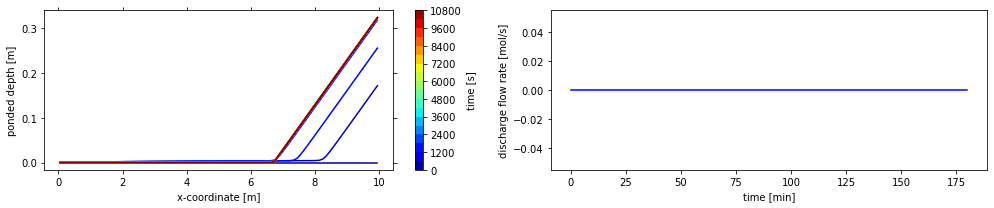

In [69]:
plot_surface("overland_flow/run_no_flow_results")

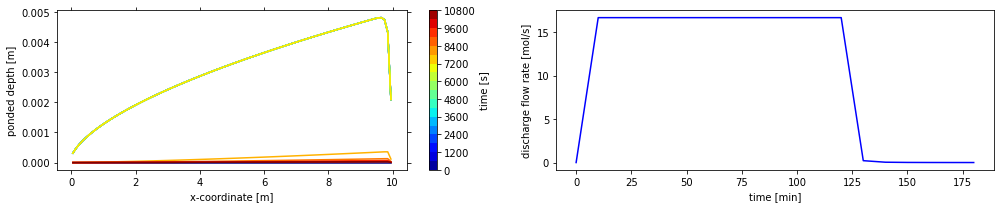

In [70]:
plot_surface("overland_flow/run_critical_depth_results")

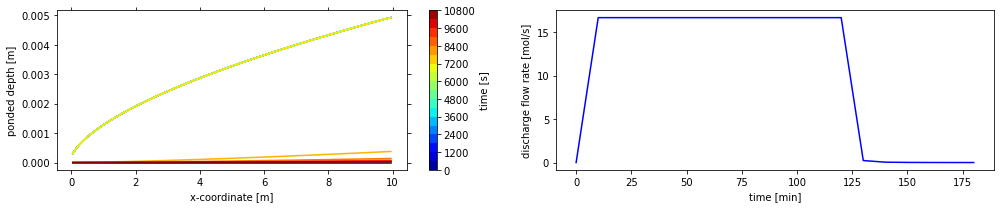

In [71]:
plot_surface("overland_flow/run_zero_gradient_results")

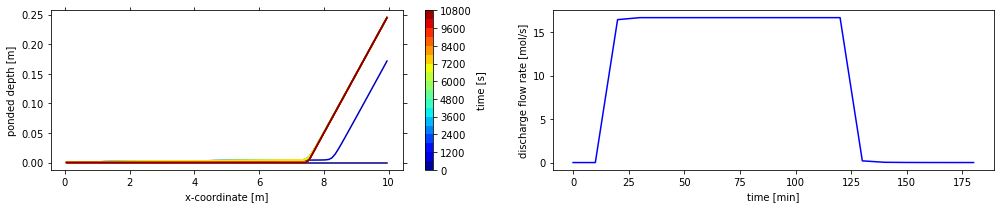

In [72]:
plot_surface("overland_flow/run_max_head_results")

### Model Setup: Rainfall on a Small Watershed 

It's much more fun to run simulations with real data.  One popular well studied small watershed is the Borden site in Ontario, Canada, which was the subject of early field studies.  It was also used in recent model intercomparions study, and so it is a relevant example for you to play with.

From the model intercomparison work we have the 0.5[m] and 1[m] DEMs, and we have used these with TINerator to make a variety of meshes.  Here we'll use the following coarse mesh to ensure simulation times are short:

<center>
<img src="overland_flow/borden_figs/borden-mesh-description.png" width=80%>
</center>

The jupyter notebook we used to generate this mesh is included in the repository for you to use to generate finer and higher quality meshes.

#### Initial and Boundary Conditions

**Initial Condition**

* Zero ponded depth (dry soil, $h=0$). 


**Boundary Conditions**

* Critical depth on the stream outlet
* Default no flow conditions elsewhere.

**Simulation Scenario**

* Heavy Rain for 18 hours
  * ParameterList for _cycle driver_ sets the start and stop times of the simulation
  * ParameterList for _surface-water_source_ prescribes the rainfall



#### Simulation Results

We plotted the results using VisIt, with custom colormaps, so you could see what is possible.  We acknowledge at least an hour is needed to get you started with VisIt, but if you're interested ask about a quick demo during the collaboration time.

<center>
<img src="overland_flow/borden_figs/borden-ponded-depth_t=01-18-19.png" width=95%>
</center>

The heavy rainfall fills the channel fairly quickly (left image is t=1[h]), the rain continues for 18 hours (middle figure) and the depth of the ponded water increases some.  However, there is flow out at the stream outlet, so the increase in the ponded depth is limited.  Finally, when the rain stops at t=18[h], the stream drains quickly, with lighter colors (lower ponded depth) visible at 19 hours.

This coarse mesh has some issues as well. Specifically, the channel is quite rough, with water appearing to be trapped and unable to drain.  Yes, this could be physically correct in some parts of the domain, but a finer mesh (and some preprocessing of the DEM, Ethan and Pin will cover this for Watershed Workflow), would help separate real from anomolous ponding and could improve the surface flow, particularly along the stream bed. 

## Integrated Hydrology

### Model Setup: 2D Transect of Open-Book Watershed

Consider a two-dimensional transect in (x,z) of an open-book watershed (V-watershed), with each cell 1[m] in y. So the cells are three-dimensional volumes, and the surface faces are two-dimensional squares (1[m]x1[m]).

<img src="integrated_hydro/figs/2D-open-book-mesh-labels.png" width="60%">

Describe how facesets are set geometrically or by labelled sets.

#### Initial and Boundary Conditions

**Initial Condition**

* Subsurface Flow
  * Water table set to 2[m] (bottom of the mesh is 0[m]).
  * Hydrostatic pressure based on this water table.
* Surface Flow
  * Set based on continuity of pressure and normal flux.


**Boundary Conditions**

* Subsurface Flow:
  * no flow boundary conditions on west, east, north, south, and bottom.
  * no boundary condition on top surface - continuity conditions are used in coupling
* Overland Flow (Surface):
  * no flow on all sides
  * usually would have an outflow condition at the stream outlet (next example).


**Simulation Scenario**

* Heavy Rain for 10 days
  * ParameterList for _cycle driver_ sets the start and stop times of the simulation
  * ParameterList for _surface-water_source_ prescribes the rainfall


#### Simulation Results

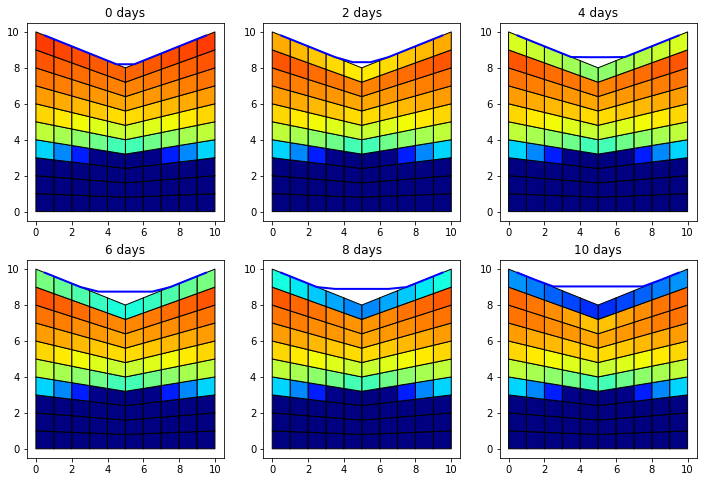

In [73]:
# Plot the saturation at a few times

import colors
from matplotlib import colorbar

vis = ats_xdmf.VisFile(directory="integrated_hydro/run_2D", 
                       filename="ih_subsurface_data.h5", 
                       mesh_filename="ih_subsurface_mesh.h5", 
                       time_unit='d')
#select output every 2 days
vis.filterIndices([0,2,4,6,8,10])
vis.loadMeshPolygons()

vis_surf = ats_xdmf.VisFile(directory="integrated_hydro/run_2D_results", 
                            domain="surface", 
                            filename="ih_surface_data.h5" , 
                            mesh_filename="ih_surface_mesh.h5", 
                            time_unit='d')
#select same output as subsurface
vis_surf.filterIndices([0,2,4,6,8,10])
vis_surf.loadMesh(order=['x','z'])

fig, axs = plt.subplots(2,3,figsize=(12,8))

def plot(i, ax):

    sat = vis.get("saturation_liquid", vis.cycles[i])
    poly = vis.getMeshPolygons(cmap='jet_r', linewidth=1)
    poly.set_array(sat)
    poly.set_clim(0.4,1)
    ax.add_collection(poly)

    elev = vis_surf.get('surface-elevation', vis.cycles[i])
    pd = vis_surf.get('surface-ponded_depth', vis.cycles[i])

    ax.plot(vis_surf.centroids[:,0], elev+pd, 'b', linewidth=2)
    ax.set_title(f"{2*i} days")
    
plot(0, axs[0,0])
plot(1, axs[0,1])
plot(2, axs[0,2])
plot(3, axs[1,0])
plot(4, axs[1,1])
plot(5, axs[1,2])

The domain is filling as the boundary conditions on the sides and bottom are _no flow_.  This is clearly visible in the saturation, although at this point the water table is only starting to rise in the at the end of the 10 days. The ponded water is also rising, but in this simulation this rise is primarily due the rainfall.  You can modify the input file to start with a higher water table, and possibly increase the permeability of the subsurface to increase infiltration - as this would ultimately cause the water table to reach the stream bed sooner, leading to groundwater contributions to the ponded water.

### Model Setup: 3D Open-Book Watershed

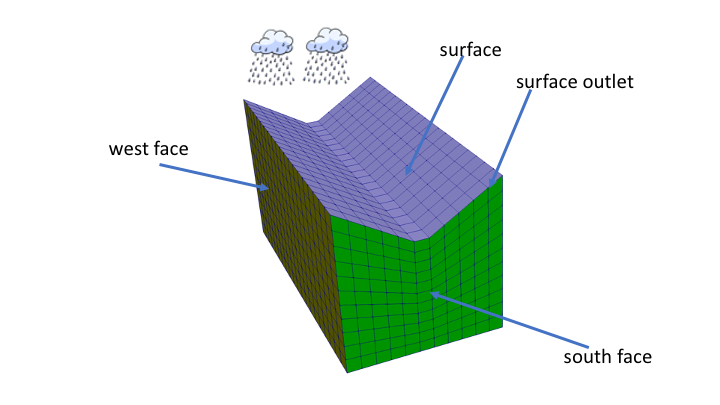

#### Parameters of 3D simulation:

**Simulation Scenario**

  * simulation start: 0.0 day
  * simulation end:  0.8 day

**Initial Condition** 

* Subsurface Flow:
  * Hydrostatic pressure with water table at 6.0[m]
* Surface Flow
  * Set based on continuity of pressure and normal flux.

**Boundary Conditions**

* Subsurface Flow:
  * no flow boundary conditions
* Surface Flow
  * Zero-gradient conditions at the stream outlet

**Rainfall Rate**

<div>
<img src="attachment:rainfall_rate.png" width="500"/>
</div>



#### Simulation Results

In [74]:
def plot_transect(directory):
    vis = ats_xdmf.VisFile(directory, domain='surface', filename='ih_surface_data.h5', mesh_filename='ih_surface_mesh.h5', time_unit='s')
    vis.loadMesh(order=['x','y'])
    y = vis.centroids[:,1]
    pd = vis.getArray('surface-ponded_depth')
    cm = colors.cm_mapper(vis.times[0], vis.times[-1], cmap='jet')
        
    fig, ax = plt.subplots(1,2, figsize=(14,3))
    
    # This simply gets a colorbar axis
    C = [[0,0],[0,0]]
    C3 = ax[0].contourf(C, vis.times, cmap='jet')
    ax[0].cla()
    
    for i,time in enumerate(vis.times):
        #ax[0].plot(x, elev + pd[i,:], color=cm(i))
        #print(cm(i))
        ax[0].plot(y[100:119], pd[i,100:119], color=cm(time))

    ax[0].set_xlabel('y-coordinate [m]')
    ax[0].set_ylabel('ponded depth [m]')
    
    cbar = plt.colorbar(C3, ax=ax[0])
    cbar.ax.set_ylabel("time [s]")
    
    #ax[0].plot(y[120:139], pd[10,120:139], 'b-')
    #ax[0].plot(y[100:119], pd[10,100:119], 'r-')
    #ax[0].plot(y[80:99], pd[10,80:99], 'g-')
    
    out_flux = np.loadtxt(os.path.join(directory,'surface_outlet_flux.dat'), skiprows=11)
    out_flux = np.transpose(out_flux)
    ax[1].plot(out_flux[0][:]/3600.0, out_flux[1][:], 'b')
    ax[1].set_xlabel('time [h]')
    ax[1].set_ylabel('discharge flow rate [mol/s]')


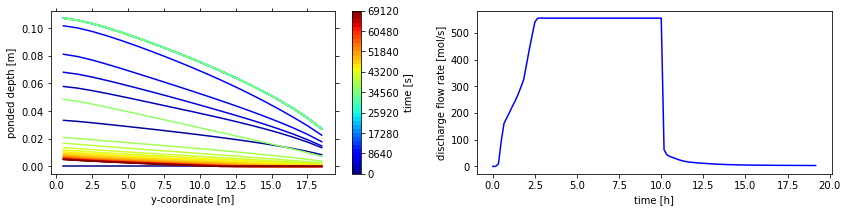

In [75]:
plot_transect('integrated_hydro/run_3D_results')

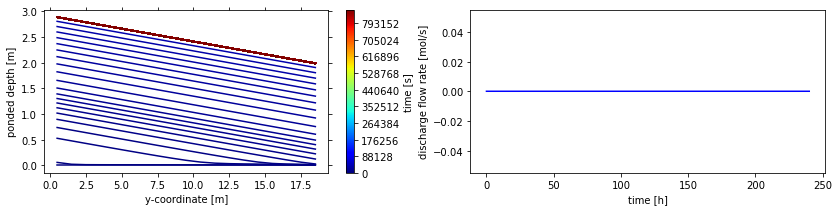

In [76]:
plot_transect('integrated_hydro/run_3D')

### Model Setup: Integrated Hydrology on Small Watershed

Building on the overland flow example where we simulated a rainfall event on the Borden Watershed, here we consider integrated hydrology at the same site. We consider a simulaton scenario similar to the model incomparison to provide a good starting point for you to modify the file and experiment.

Here are sample results, showing the subsurface is filling (saturation is increasing) as the stream depth is rising from the rainfall.

<center>
<img src="integrated_hydro/figs/integrated_hydro-borden-t=10-60min.png" width=90%>
</center>

The input file is *integrated_hydro-borden_rainfall.xml*, and the VisIt session file is *integrated_hydro-borden_rainfall.session*
